In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
from glob import glob
from astropy.io import fits
%matplotlib notebook

## Load Jim's long period maybe-EB file with about 1800 stars in it

In [2]:
jimLongPeriodFile = '/Users/Meredith/Astronomy/github/helloTESS/outputs/longerP_rot_out.csv'
longPeriod = pd.read_csv(jimLongPeriodFile)
longPeriod.set_index('Unnamed: 0', inplace=True)
TicEclipsing = longPeriod.loc[longPeriod['ecl_flg'] == 1, 'TIC']

## Load the Gaia-TESS Crossmatch files from Trevor & Jim
See https://github.com/tzdwi/TESS-Gaia for more details

In [3]:
sec1File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess1_xmatch_1arsec-result.csv'
sec2File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess2_xmatch_1arsec-result.csv'
sec3File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess3_xmatch_1arsec-result.csv'
sec4File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess4_xmatch_1arsec-result.csv'
sec5File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess5_xmatch_1arsec-result.csv'
sec6File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess6_xmatch_1arsec-result.csv'
sec7File = '/Users/Meredith/Astronomy/github/TESS-Gaia/gaiatess7_xmatch_1arsec-result.csv'

In [4]:
sec1Xmatch = pd.read_csv(sec1File)
sec2Xmatch = pd.read_csv(sec2File)
sec3Xmatch = pd.read_csv(sec3File)
sec4Xmatch = pd.read_csv(sec4File)
sec5Xmatch = pd.read_csv(sec5File)
sec6Xmatch = pd.read_csv(sec6File)
sec7Xmatch = pd.read_csv(sec7File)

In [5]:
sec1Xmatch.columns

Index(['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'ra.1', 'dec.1', 'source_id.1', 'r_est', 'r_lo', 'r_hi', 'r_len',
       'result_flag', 'modality_flag', 'dist'],
      dtype='object', length=111)

## Based on manual search in my previous notebook, define+update "interesting" target list
These systems actually show eclipses by eye

In [215]:
TicInteresting = [30034081, 25155310, 31273263, 30313682, 32000625]

## The function that makes it all possible!!
Also now on github: https://github.com/mrawls/tess-tools/tessLightcurvePlotter.py

In [62]:
def plotTessLightcurve(tic, downloadDir='/Users/Meredith/.lightkurve-cache/mastDownload/TESS/',
                        sectorList=[1, 2, 3, 4, 5, 6, 7], offset=0, save=False):
    #plt.figure(figsize=(8,4))
    tpf = None
    lc = None
    for sector in sectorList:
        filePath = glob(downloadDir + 'tess*s000' + str(sector) + '*' + str(tic) + '*/*.fits')
        if len(filePath) > 0:  # the file is on disk
            filePath.append(filePath[0])
            tpf = lk.TessTargetPixelFile(filePath[0])
        else:  # the file isn't on disk
            if list(search_targetpixelfile(tic, sector=sector)):  # nonzero search results
                print('Downloading sector {0} for star {1}'.format(sector, tic))
                tpf = search_targetpixelfile(tic, sector=sector).download()
        if tpf and not lc:
            lc = tpf.to_lightcurve().normalize()
        elif tpf and lc:
            newlc = tpf.to_lightcurve().normalize()
            lc = lc.append(newlc)
        else:
            pass  # there is no tpf for this target + sector
    if lc:
        plt.plot(lc.time, lc.flux - offset, label=tic, marker='.', ls='None', alpha=0.2, mec='None')
        if save:
            hdu = lc.to_fits(path=str(tic)+'Norm.fits', overwrite=True)
    else:
        print(tic, 'No LC found for any sector')
    plt.xlabel('Time (days)')
    plt.ylabel('Normalized flux')
    plt.legend()
    plt.gca().set_ylim(0.5, 1.1)

<IPython.core.display.Javascript object>


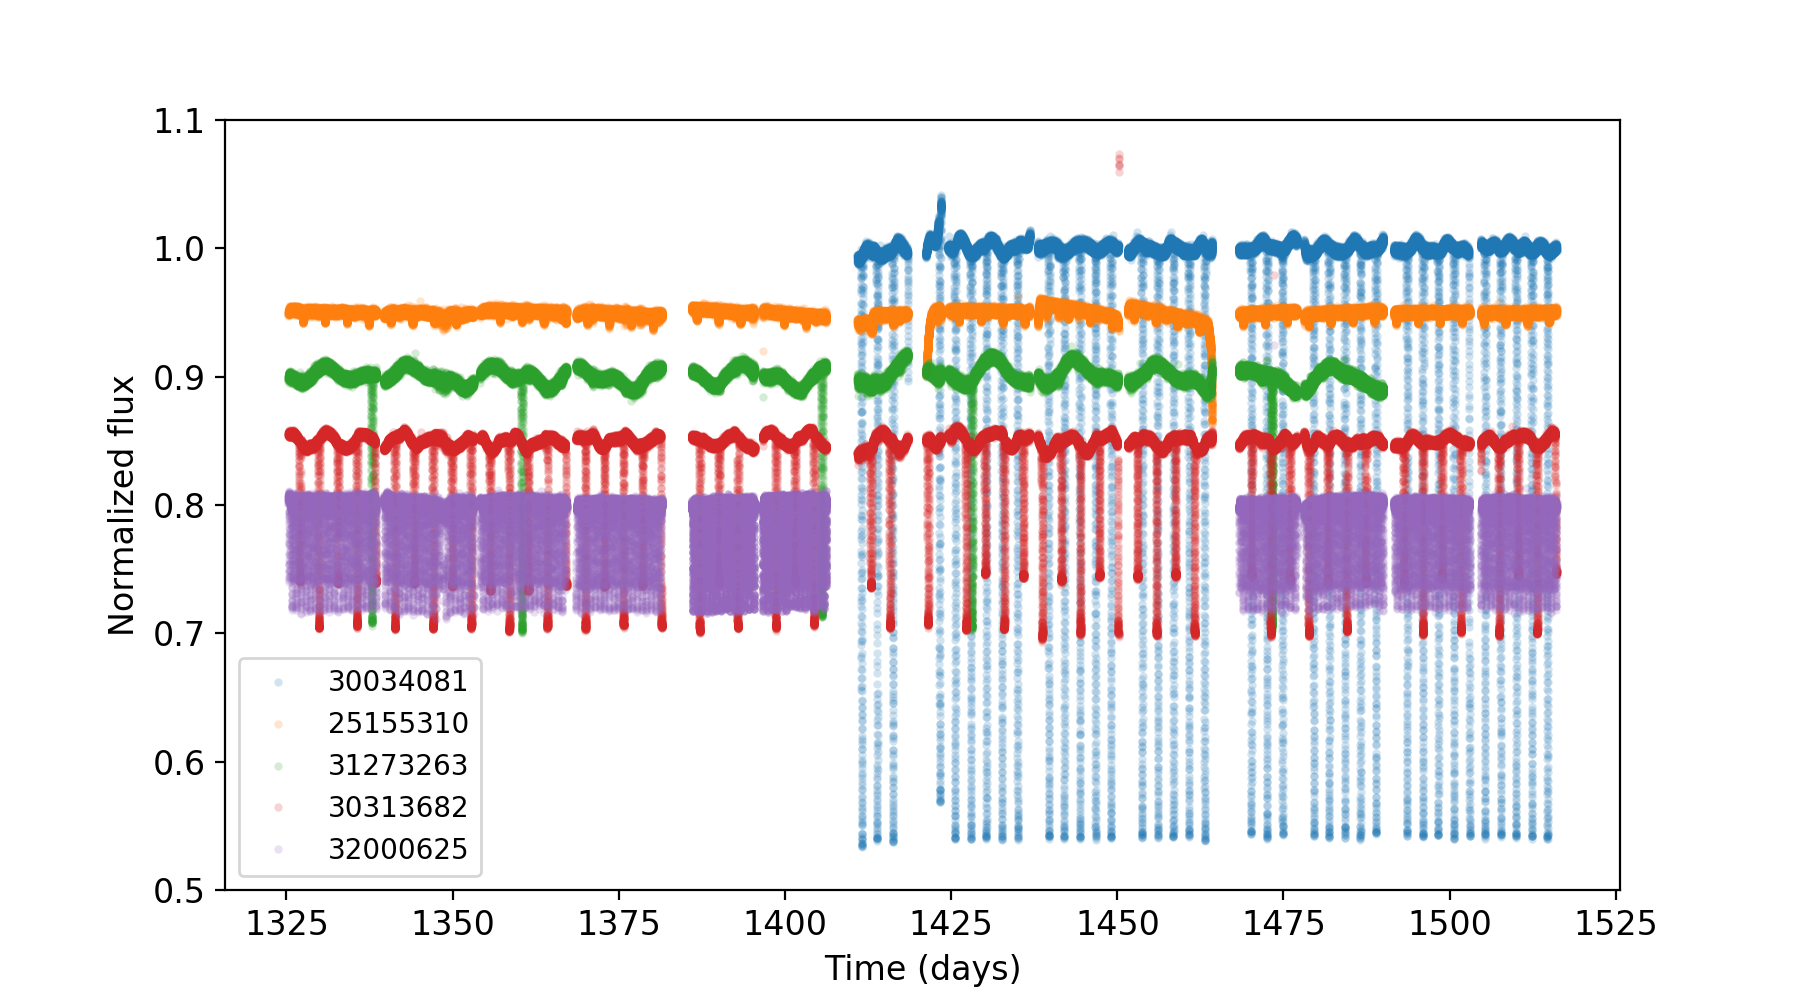

In [216]:
plt.figure(figsize=(9,5))
for idx, tic in enumerate(TicInteresting):
    plotTessLightcurve(tic, offset=0.05*idx, save=True)

## Check to see which targets are in which sectors

In [217]:
for tic in TicInteresting:
    print(tic)
    print('1', tic in sec1Xmatch.ticid.values)
    print('2', tic in sec2Xmatch.ticid.values)
    print('3', tic in sec3Xmatch.ticid.values)
    print('4', tic in sec4Xmatch.ticid.values)
    print('5', tic in sec5Xmatch.ticid.values)
    print('6', tic in sec6Xmatch.ticid.values)
    print('7', tic in sec7Xmatch.ticid.values)

30034081
1 False
2 False
3 False
4 True
5 True
6 True
7 True
25155310
1 True
2 True
3 True
4 True
5 True
6 True
7 True
31273263
1 True
2 True
3 True
4 True
5 True
6 True
7 False
30313682
1 True
2 True
3 True
4 True
5 True
6 True
7 True
32000625
1 True
2 True
3 True
4 False
5 False
6 True
7 True


In [317]:
for tic in (TicInteresting):
    sector = 6
    downloadDir='/Users/Meredith/.lightkurve-cache/mastDownload/TESS/'
    filePath = glob(downloadDir + 'tess*s000' + str(sector) + '*' + str(tic) + '*/*.fits')
    filePath.append(filePath[0])
    tpf = lk.TessTargetPixelFile(filePath[0])
    print(tpf.targetid)
    print(tpf.ra)
    print(tpf.dec)
    tpf.interact()

30034081
73.028836
-70.731228


25155310
63.37389
-69.226789


31273263
88.103635
-68.159538


30313682
74.190743
-66.890974


32000625
55.987954
-71.479043


## Update metadata for the TicInteresting target list on the fly

In [221]:
TicInteresting

[30034081, 25155310, 31273263, 30313682, 32000625]

In [248]:
TicStarInfo = ['V* AT Men, long known G0 EB', 'WASP-126b, exoplanet candidate',
               'HD 270269, F5 spectroscopic binary', 'HD 268734, in RAVE 5th DR', 'TYC 9155-22-1']

In [225]:
TicStarGaiaBpMeanMag = []
TicStarGaiaRpMeanMag = []
TicStarGaiaGMeanMag = []
TicStarGaiaParallax = []

In [313]:
df = sec6Xmatch.loc[sec6Xmatch.ticid == TicInteresting[4]]  # literally the worst way to do this... manual iteration

In [240]:
TicStarGaiaBpMeanMag.append(df.phot_bp_mean_mag.values[0])
TicStarGaiaRpMeanMag.append(df.phot_rp_mean_mag.values[0])
TicStarGaiaGMeanMag.append(df.phot_g_mean_mag.values[0])
TicStarGaiaParallax.append(df.parallax.values[0])

In [314]:
TicStarGaiaBpMeanMag

[11.384631, 11.433264, 11.700638, 10.884772, 12.021308]

In [315]:
TicStarGaiaRpMeanMag

[10.542078, 10.561916, 10.739111999999999, 10.016308, 10.997144]

In [316]:
TicStarGaiaGMeanMag
TicStarGaiaAbsG = np.array(TicStarGaiaGMeanMag) + 5*np.log10(np.array(TicStarGaiaParallax)) - 10
print(TicStarGaiaAbsG)

[3.03707118 4.37529633 2.78061587 2.83912416 4.53377187]


## Plot the interesting eclipsing systems on an H-R diagram
The other points are all of the ~1800 maybe-EBs from Jim's initial hellotess long period search

<IPython.core.display.Javascript object>


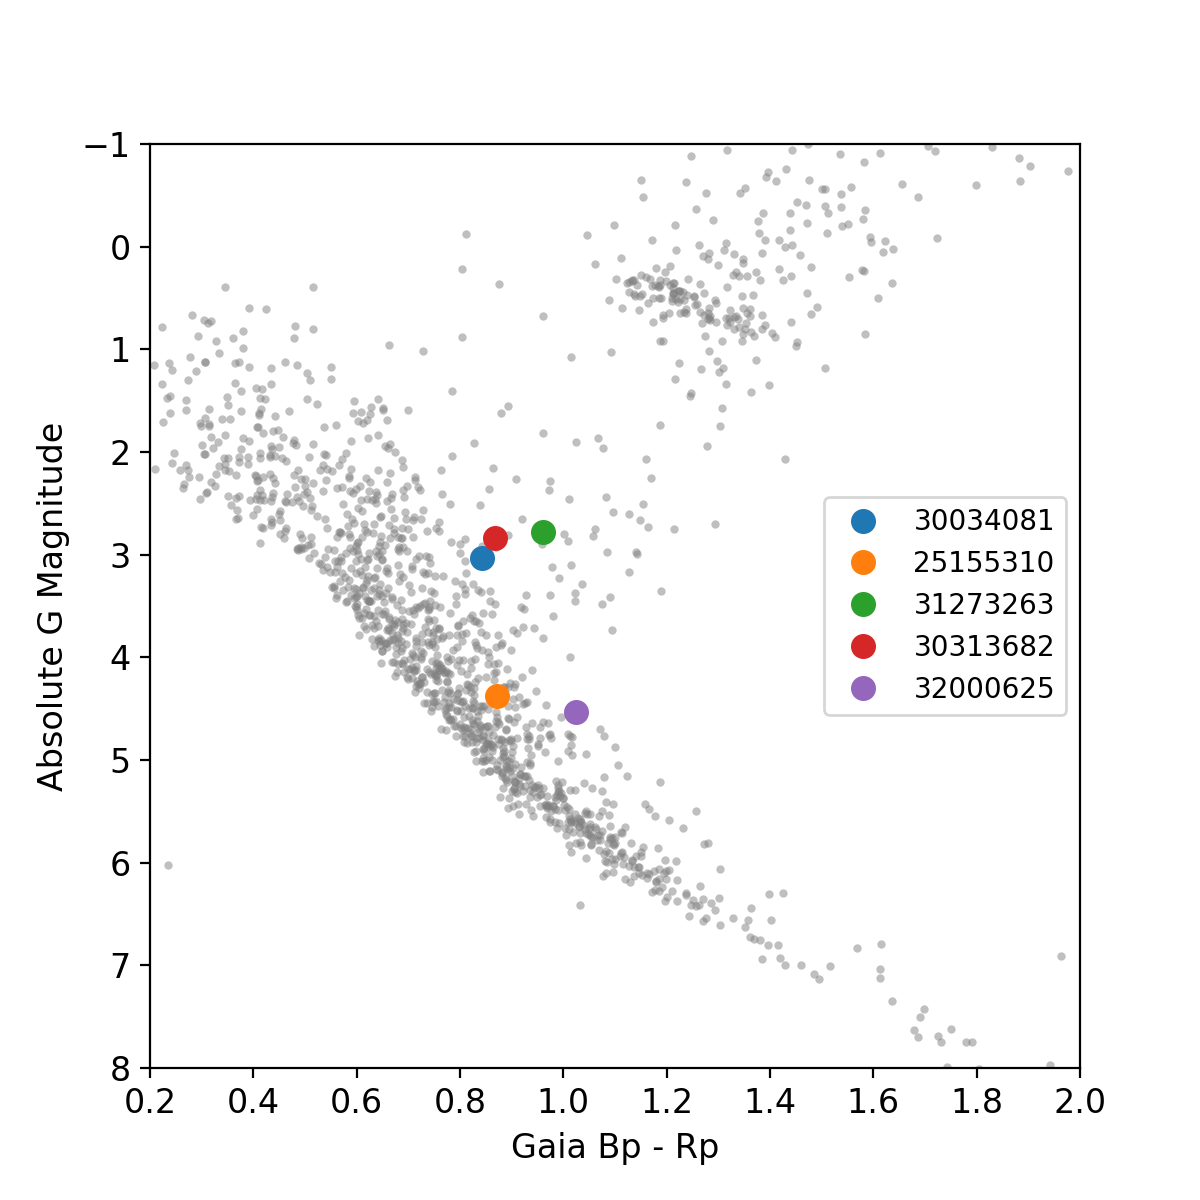

/Users/Meredith/LSST/lsstsw/miniconda/envs/astroconda/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


[0.2, 2, 8, -1]

In [310]:
plt.figure(figsize=(6,6))
plt.plot(eclipsingXmatch.phot_bp_mean_mag - eclipsingXmatch.phot_rp_mean_mag, eclipsingXmatch.phot_g_mean_mag + 5*np.log10(eclipsingXmatch.parallax) - 10, 
         marker='.', color='0.5', ls='None', mec='None', alpha=0.5)
for idx, star in enumerate(TicInteresting):
    b_minus_r = TicStarGaiaBpMeanMag[idx] - TicStarGaiaRpMeanMag[idx]
    absG = TicStarGaiaAbsG[idx]
    plt.plot(b_minus_r, absG, marker='o', ls='None', ms=8, label=star)
plt.xlabel('Gaia Bp - Rp')
plt.ylabel('Absolute G Magnitude')
plt.legend()
plt.axis([0.2, 2, 8, -1])

In [189]:
df.columns.values

array(['solution_id', 'designation', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

In [246]:
df.ra

7888    55.988009
Name: ra, dtype: float64

In [247]:
df.dec

7888   -71.478952
Name: dec, dtype: float64

## Make a big crossmatch dataframe with all sectors with no duplicate TICs

In [284]:
secAllList = [sec1Xmatch, sec2Xmatch, sec3Xmatch, sec4Xmatch, sec5Xmatch, sec6Xmatch, sec7Xmatch]
secAllXmatch = pd.concat(secAllList, sort=True).drop_duplicates(subset='ticid').reset_index(drop=True)

## Refine the all-sector crossmatch to only include Jim's ~1800 maybe-EBs

In [286]:
eclipsingXmatch = secAllXmatch[secAllXmatch['ticid'].isin(list(TicEclipsing))]

In [319]:
len(eclipsingXmatch)

1778

## More refinement: looking for evolved stars only

In [299]:
# evolved: absG < 3 and B-R > 1
absG = eclipsingXmatch['phot_g_mean_mag'] + 5*np.log10(eclipsingXmatch['parallax']) - 10
#np.array(TicStarGaiaGMeanMag) + 5*np.log10(np.array(TicStarGaiaParallax)) - 10
evolved = ((eclipsingXmatch['phot_g_mean_mag'] + 5*np.log10(eclipsingXmatch['parallax']) - 10 < 3) &
           (eclipsingXmatch['phot_bp_mean_mag'] - eclipsingXmatch['phot_rp_mean_mag'] > 1))

/Users/Meredith/LSST/lsstsw/miniconda/envs/astroconda/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/Meredith/LSST/lsstsw/miniconda/envs/astroconda/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


In [300]:
evolvedXmatch = eclipsingXmatch.loc[evolved]

In [301]:
len(evolvedXmatch)

322

## New manual light curve search, 10 at a time, to look for eclipsing systems...

<IPython.core.display.Javascript object>


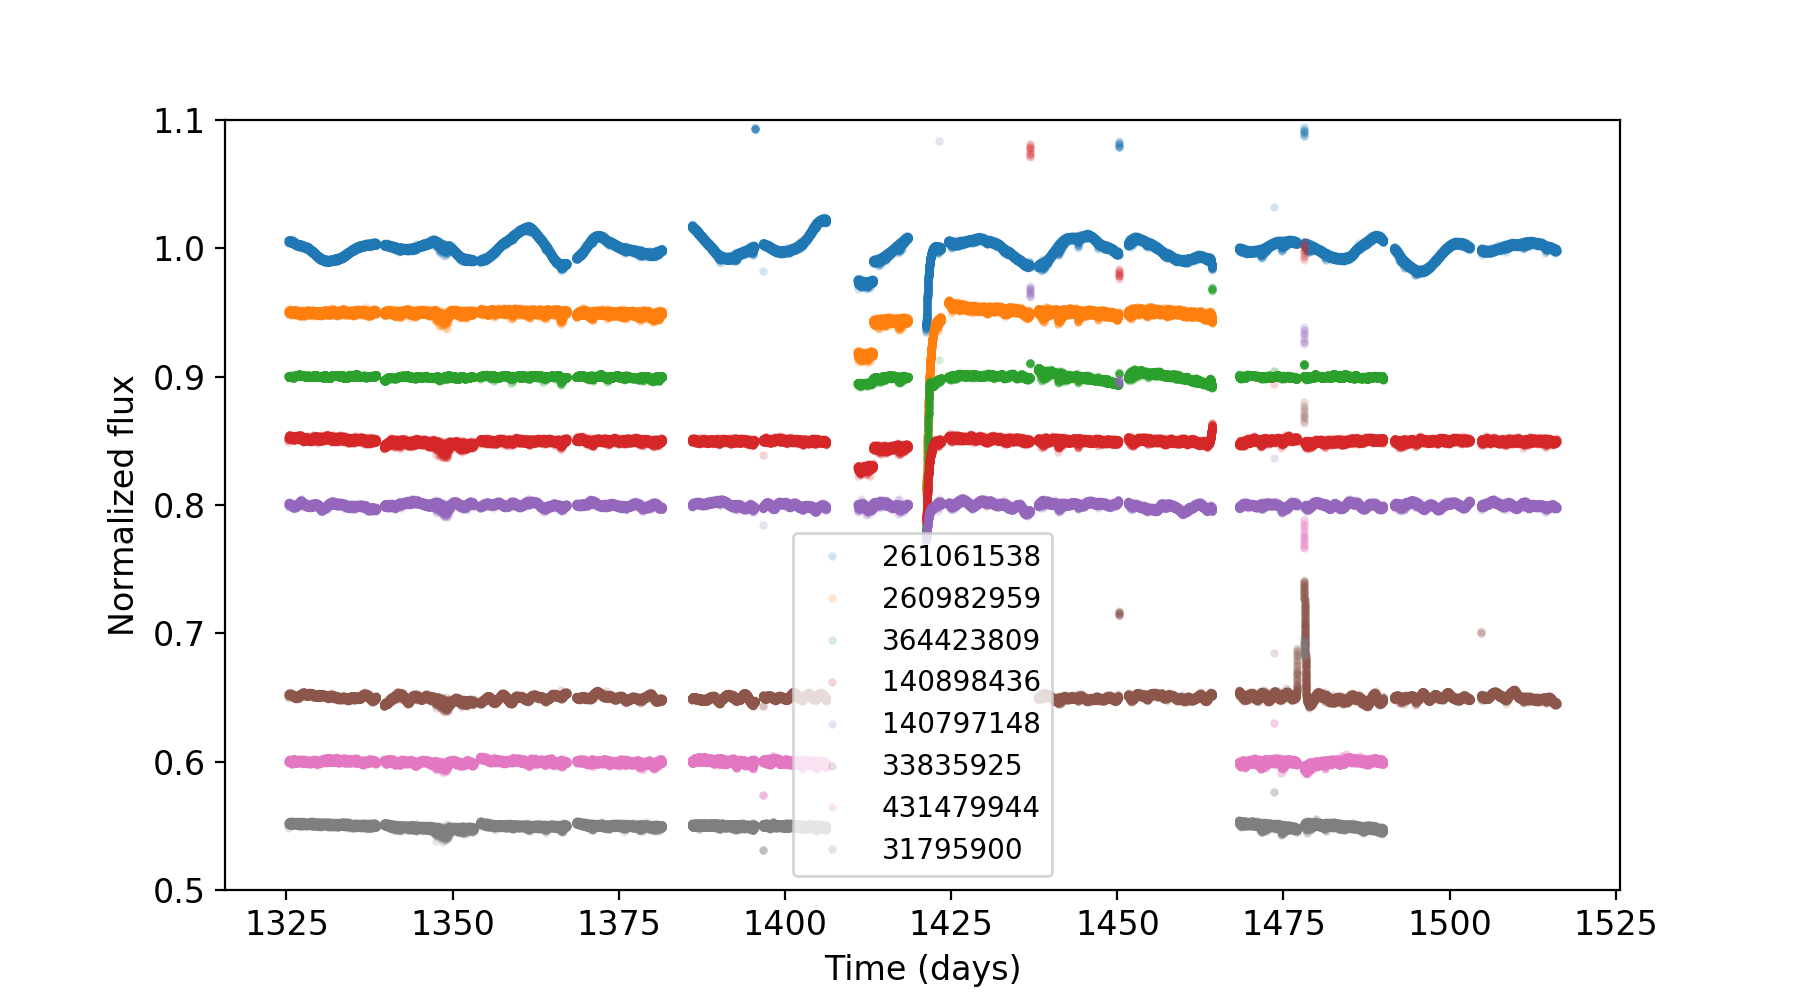

No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".
No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".
No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".
No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".
No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".
No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".
No data found for target "231739745".
ERROR:lightkurve.search:No data found for target "231739745".


231739745 No LC found for any sector


No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".
No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".
No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".
No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".
No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".
No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".
No data found for target "238196326".
ERROR:lightkurve.search:No data found for target "238196326".


238196326 No LC found for any sector


In [303]:
plt.figure(figsize=(9,5))
for idx, tic in enumerate(list(evolvedXmatch['ticid'].values)[0:10]):
    plotTessLightcurve(tic, offset=0.05*idx, save=False)

<IPython.core.display.Javascript object>


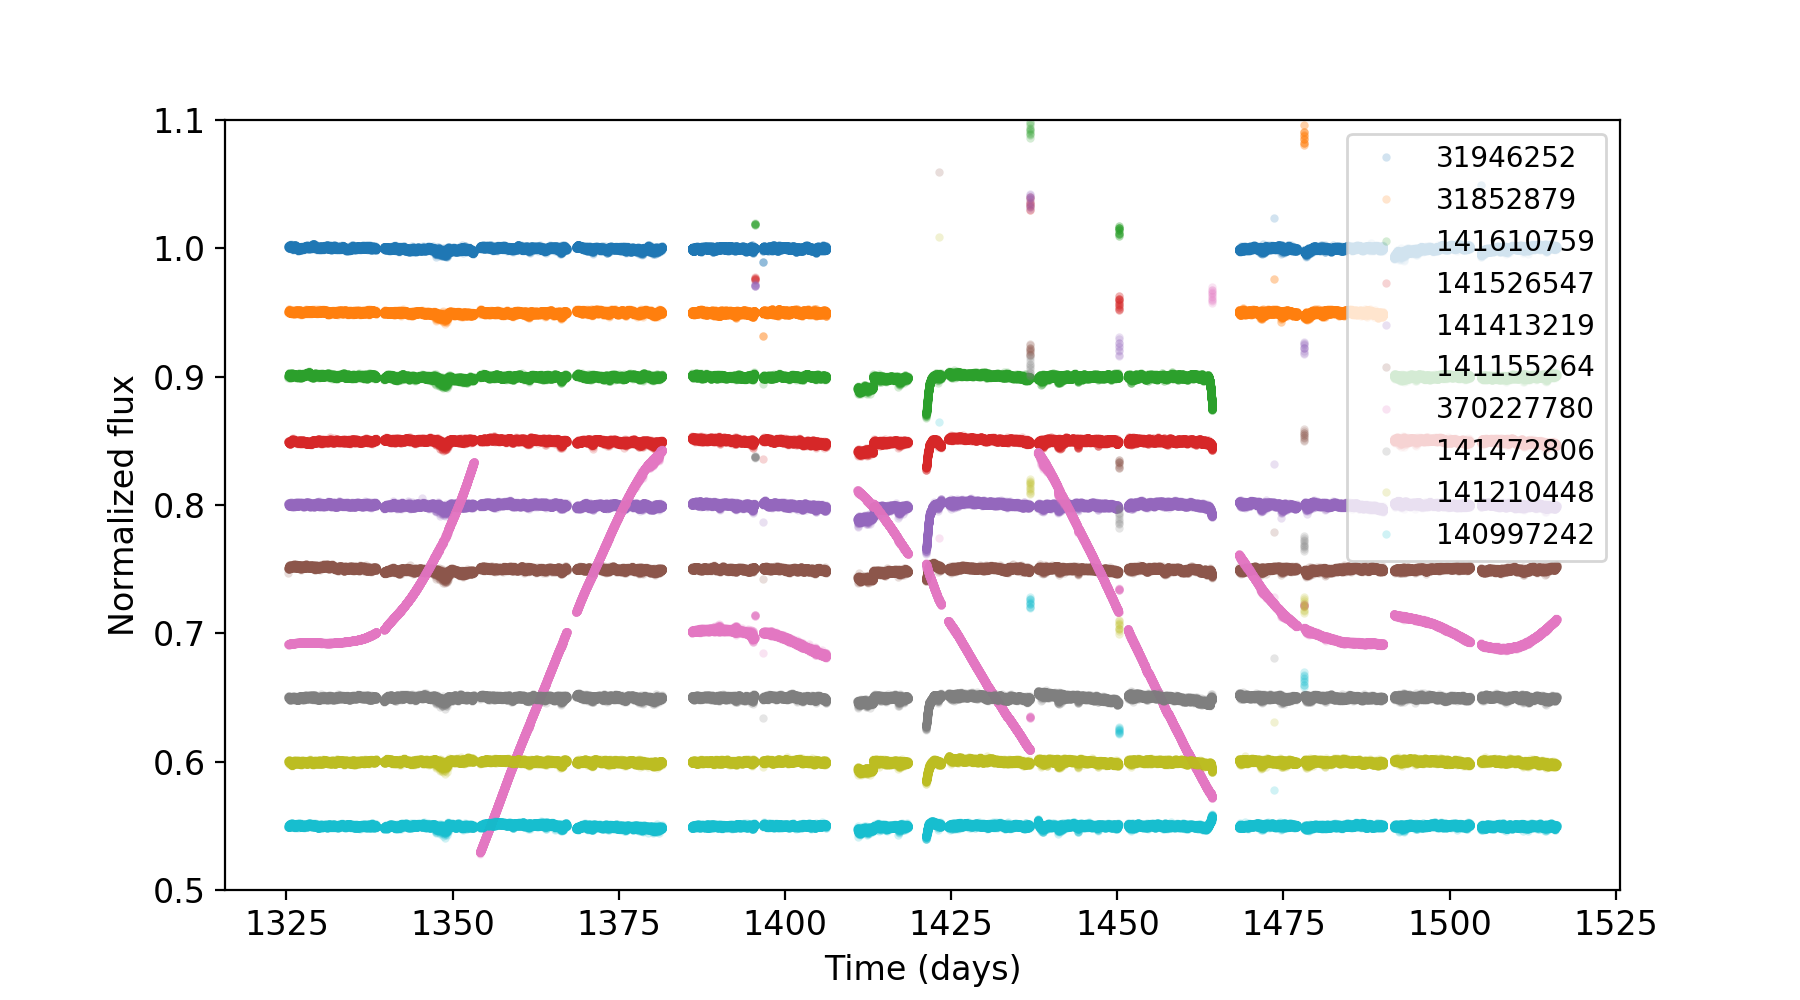

In [311]:
plt.figure(figsize=(9,5))
for idx, tic in enumerate(list(evolvedXmatch['ticid'].values)[10:20]):
    plotTessLightcurve(tic, offset=0.05*idx, save=False)

<IPython.core.display.Javascript object>


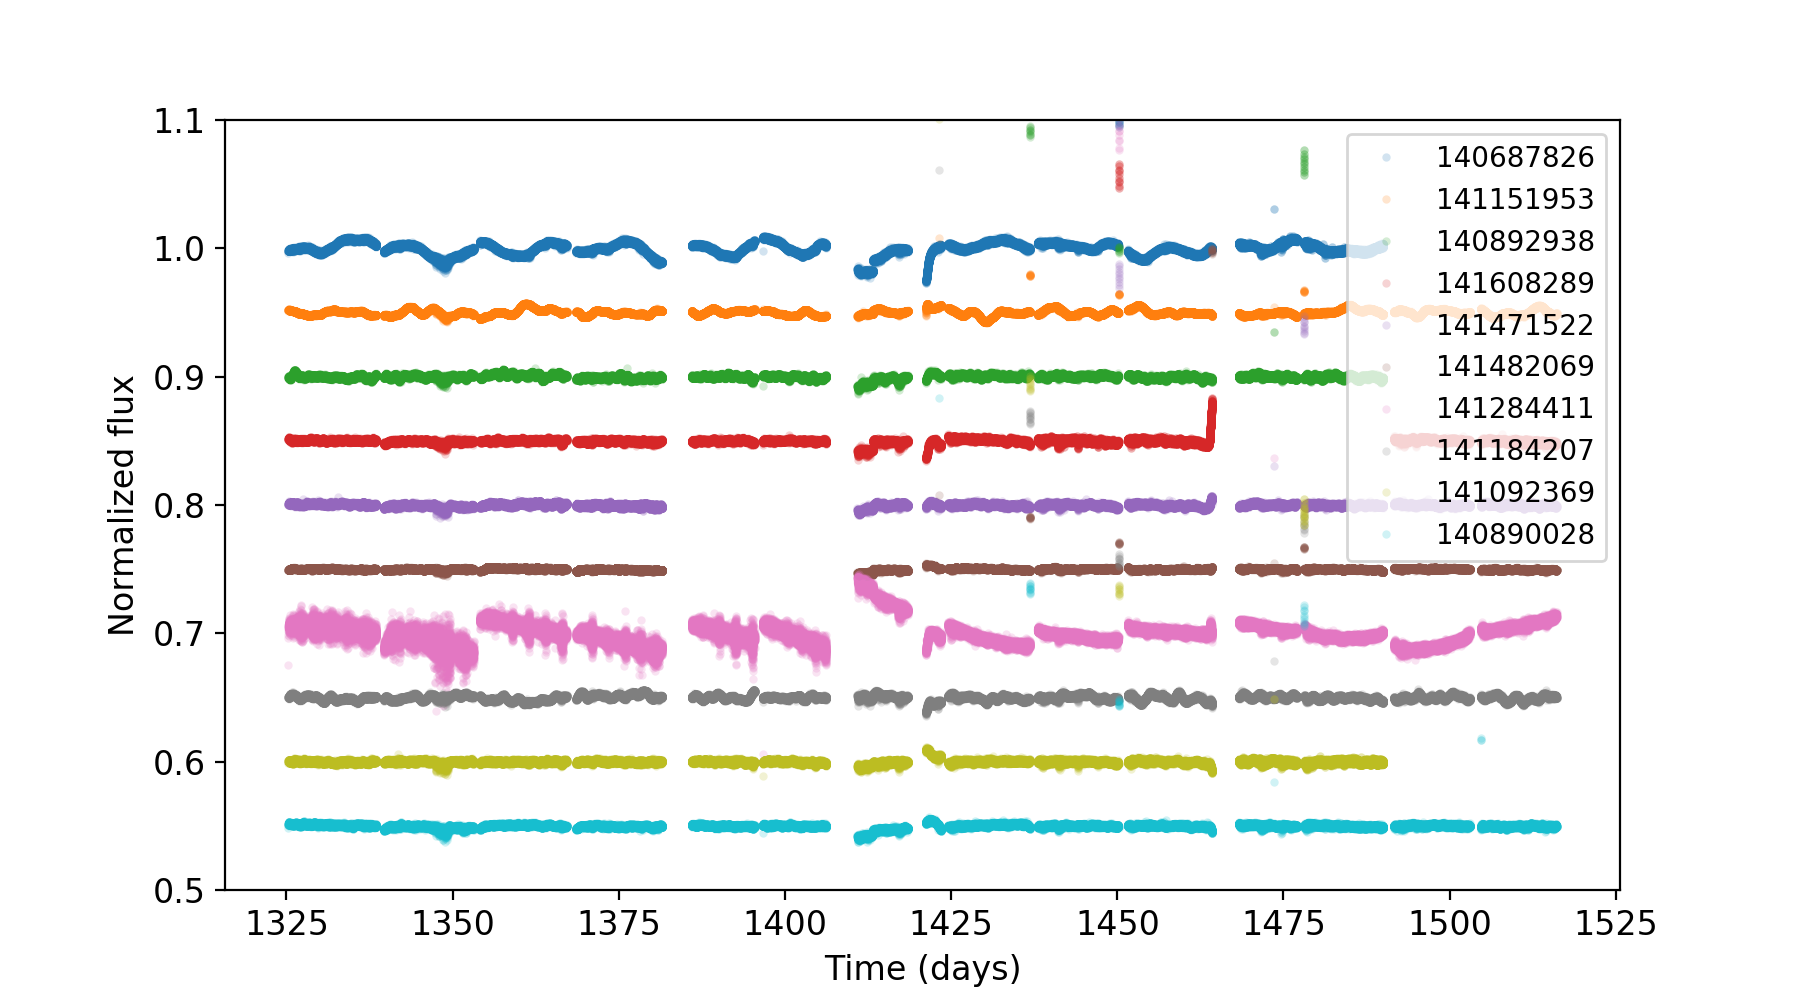

In [312]:
plt.figure(figsize=(9,5))
for idx, tic in enumerate(list(evolvedXmatch['ticid'].values)[20:30]):
    plotTessLightcurve(tic, offset=0.05*idx, save=False)